# Generating dataset

In [1]:
import sys
sys.path.append('../simulator')

from AgentBasedModel import *
from AgentBasedModel.extra import *
import AgentBasedModel.settings as settings
from AgentBasedModel.visualization import (
    plot_price,
    plot_price_fundamental,
    plot_liquidity,
    plot_orderbook_imbalance,
    plot_trade_imbalance,
    plot_spread,
    plot_gain
)
from random import randint
from pathlib import Path

import random

datasets_quantity = 1

stocks_quantity = 10

simulator_iterations = 500

risk_free_rate = 5e-4
        
price = 100
        
dividend = price * risk_free_rate


assets = [
    Stock(dividend) for _ in range(stocks_quantity)
]

    # Exchange agent (intermediary between market and customer)
exchanges = [
    ExchangeAgent(assets[i], risk_free_rate) for i in range(stocks_quantity) #for x in range(10)   # single asset
]

    # Market customers
traders = [
    *[Random(exchanges[randint(0, stocks_quantity - 1)])         for _ in range(50)],
    *[Fundamentalist(exchanges[randint(0, stocks_quantity - 1)]) for _ in range(50)],
    *[Chartist2D(exchanges)                                      for _ in range(20)],
    *[MarketMaker2D(exchanges)                                   for _ in range(5)]
]

    # Run simulation
simulator = Simulator(**{
    'assets': assets,
    'exchanges': exchanges,
    'traders': traders,
    #'events': [MarketPriceShock(0, 200, -10)]
})


def simulate() -> SimulatorInfo:
    # Initialization of stocks

    info = simulator.info

    simulator.simulate(simulator_iterations, silent=False)

    return info
      

# Saving metrics
def collect_save_dataset(info: SimulatorInfo, iteration: int):

    metrics = {
        #"gain": lambda:plot_gain(info, idx = 1, left_iter=1, right_iter=simulator_iterations, show = True),
        #"spread":lambda:plot_spread(info, idx = 1, left_iter=1, right_iter=simulator_iterations, show = True),
        #"obi":lambda:plot_orderbook_imbalance(info, show=True,level = 10),
        #"timb":lambda:plot_trade_imbalance(info, delta = 1, show = True),
        #"obi_1":lambda:plot_orderbook_imbalance(info,show = True, level = 1),
        #"obi_2":lambda:plot_orderbook_imbalance(info,show = True, level = 2),    
        "price":lambda:plot_price(info, show = False, spread=False)
    }

    for i in range(10):
       metrics[f'obi_level_{i+1}'] = lambda i = i:plot_orderbook_imbalance(info,level = i+1, show = False)

    for i in range(10):
        metrics[f'tfi_delta_{i}'] = lambda i = i:plot_trade_imbalance(info,delta = i+1,show = False)

    #metrics.update(obi_levels)

    for metric, func in metrics.items():
        dataset = func()
        #dataset.to_csv(f'dataset/{metric}_{iteration}.csv')         
        dataset.to_csv(f'../dataset/{metric}.csv')         
           
            

In [2]:
info = simulate()

Simulation: 100%|██████████| 500/500 [00:06<00:00, 71.43it/s]


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


c:\Users\aslan\OneDrive\Рабочий стол\Coursework\models\../simulator\AgentBasedModel\visualization\market.py:191: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


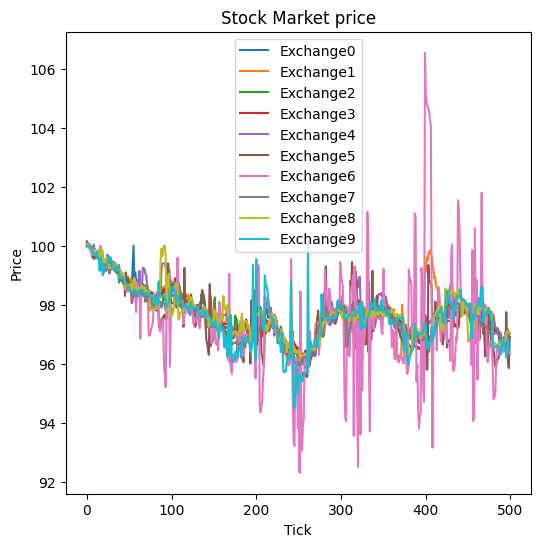

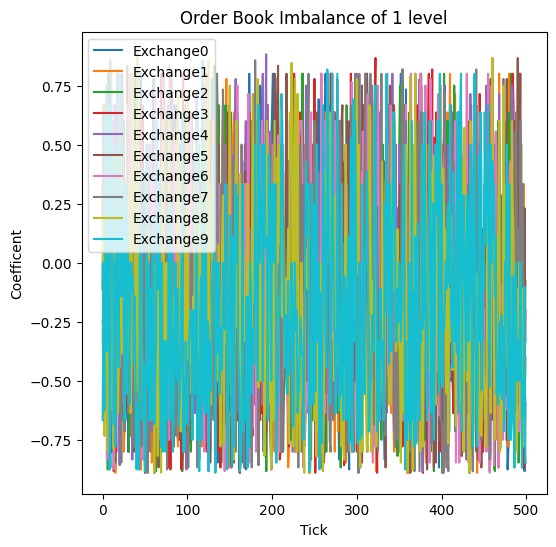

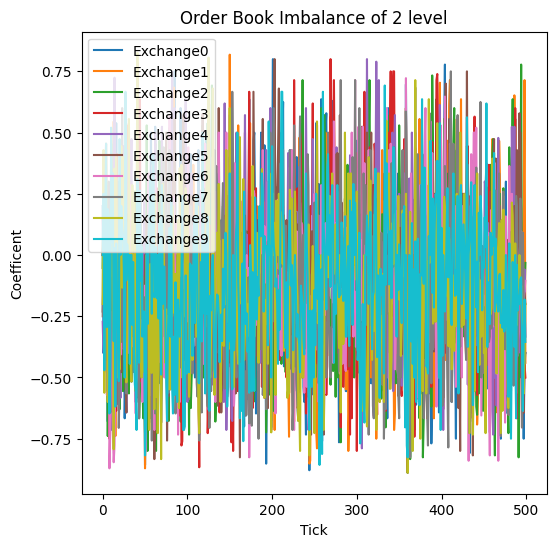

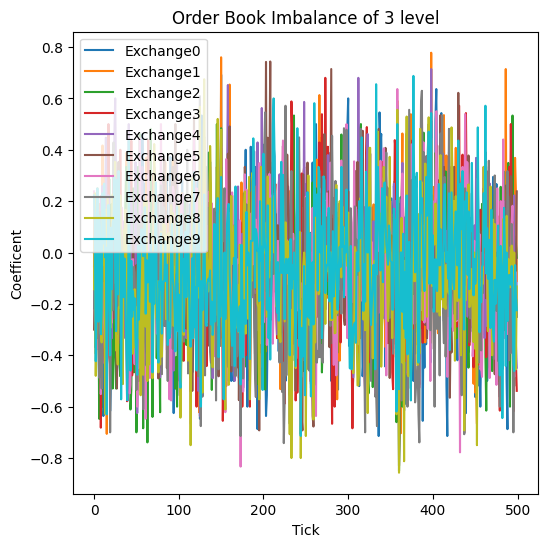

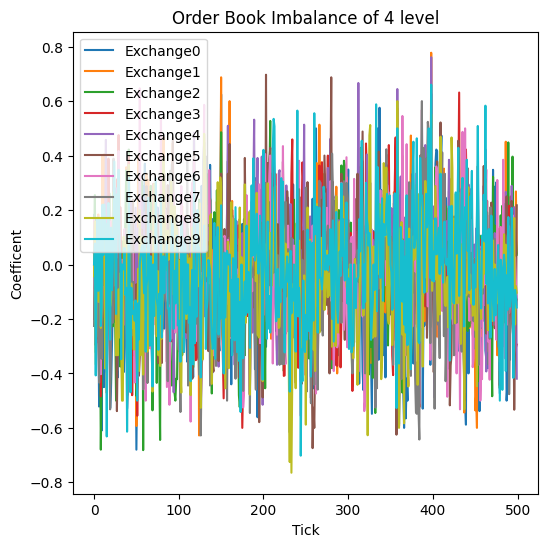

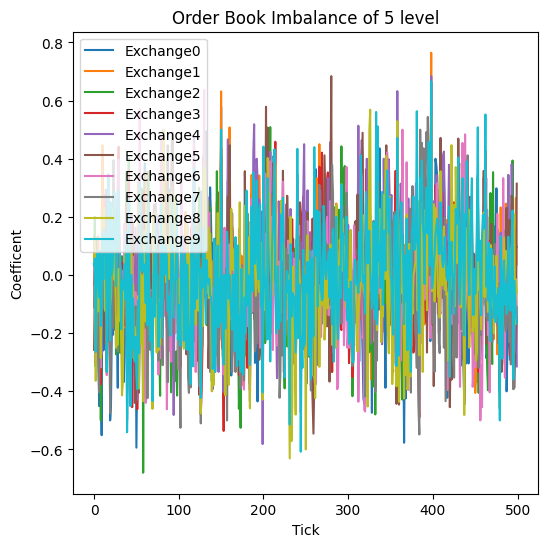

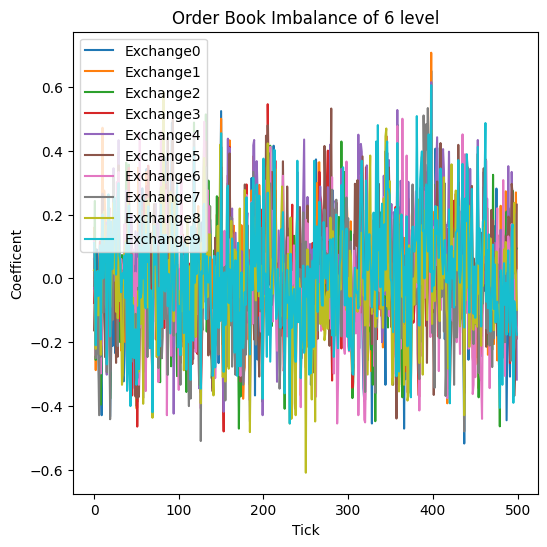

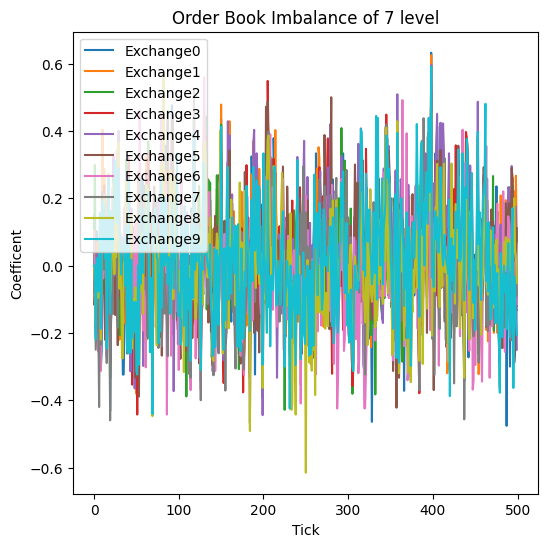

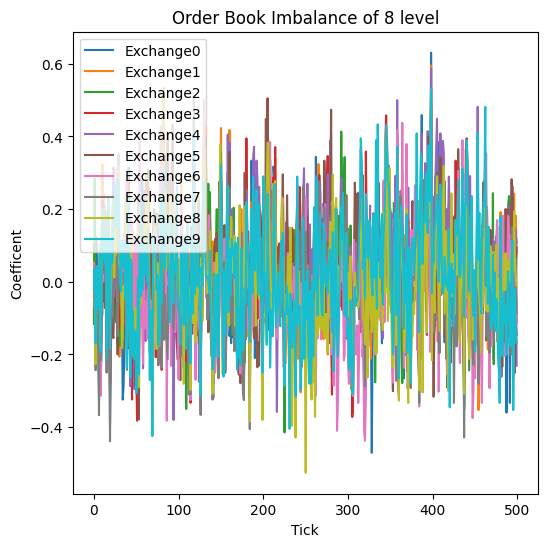

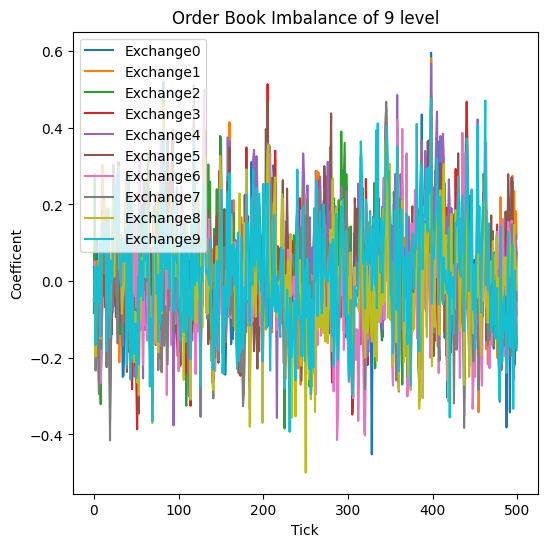

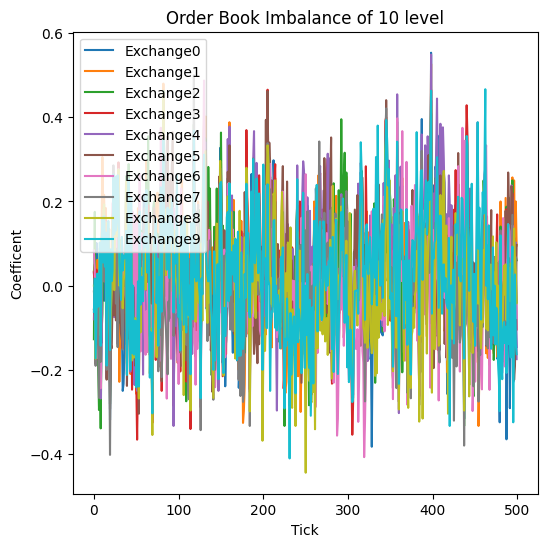

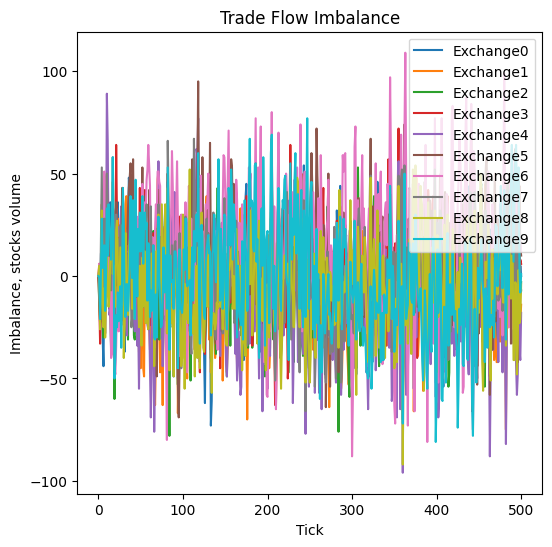

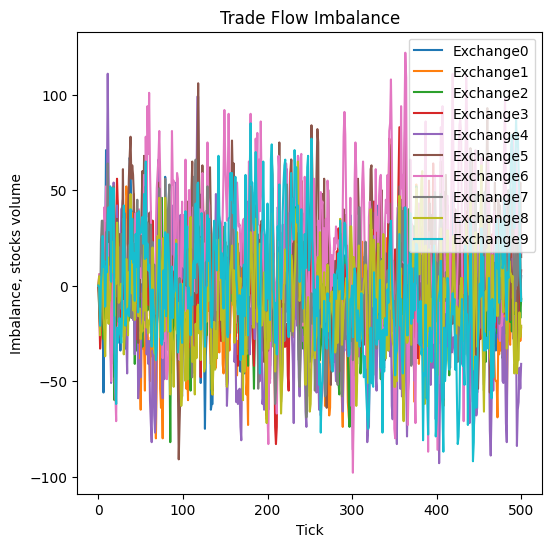

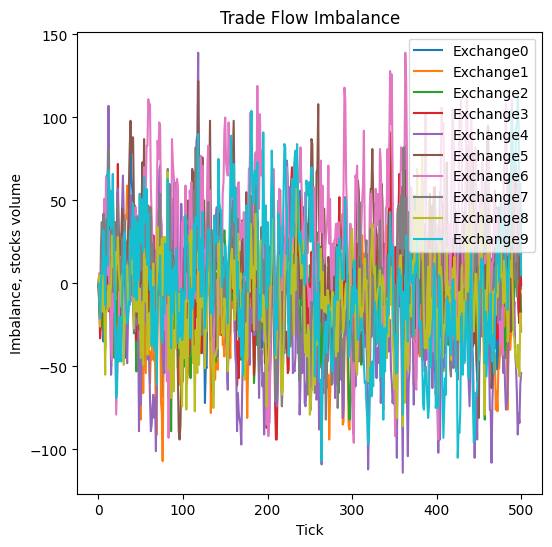

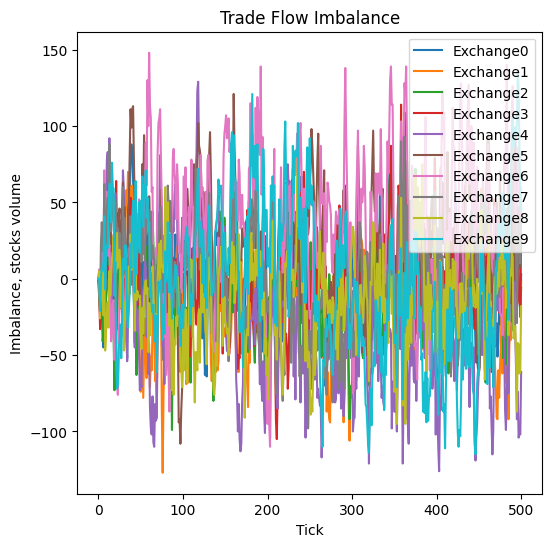

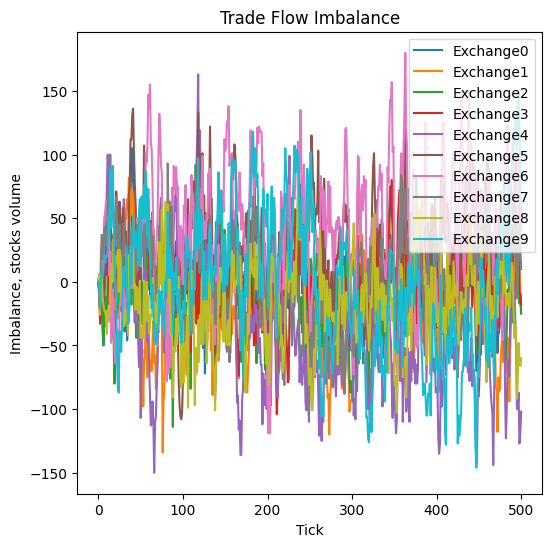

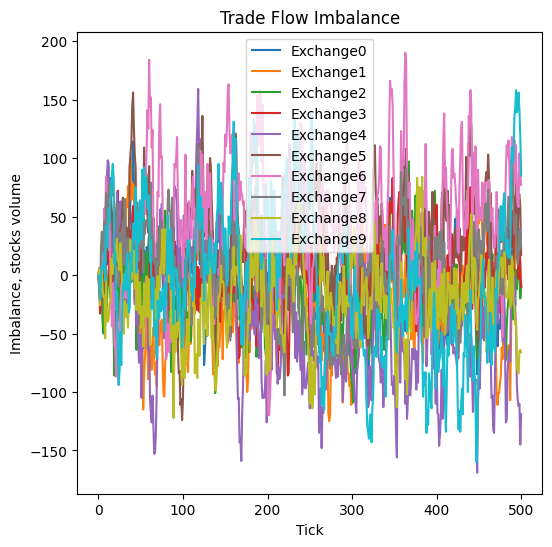

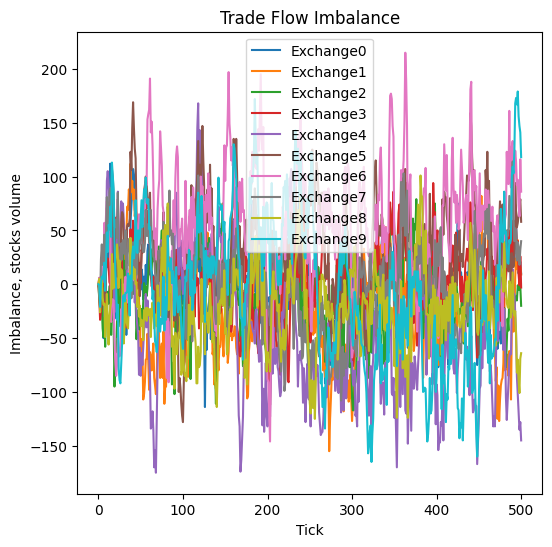

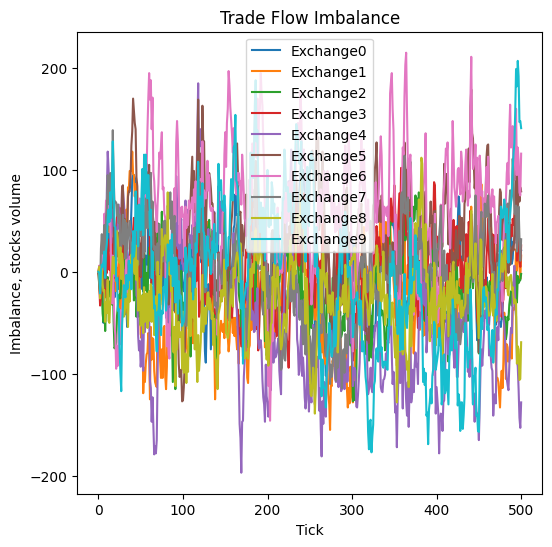

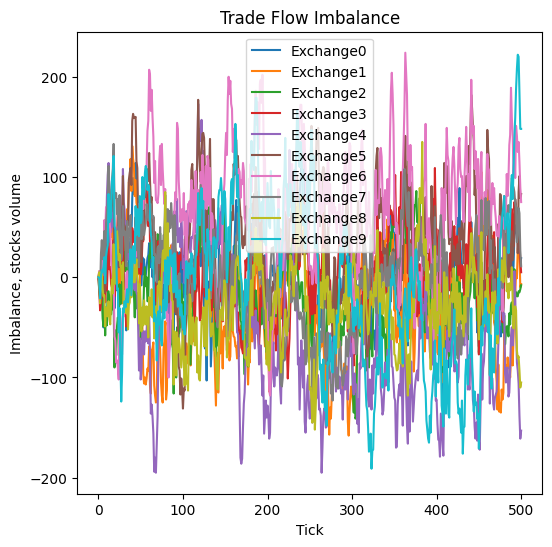

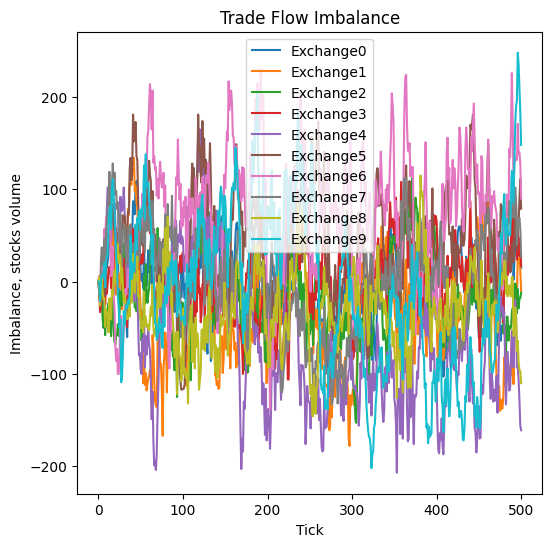

In [3]:
collect_save_dataset(info,iteration=0)

# Data processing

In [4]:
import os
import pandas as pd
import numpy as np
import sklearn
import catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

In [5]:
# reading files

def get_metrics():
    directory = '../dataset'

    files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    dfs = {}

    for file in files:
        file_path = os.path.join(directory,file)
        df = pd.read_csv(file_path)
        df.drop(df.columns[0],inplace = True,axis = 1)
        dfs[file] = df
    
    return dfs

In [6]:
dfs = get_metrics()

In [7]:
dfs['obi_level_1.csv'].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [8]:
# target
y = dfs['price.csv']['0']

dfs.pop('price.csv')

array_X = []

for i in range(stocks_quantity):
    array_X.append(pd.concat([value.iloc[:,:i+1] for key, value in dfs.items()],axis = 1))


In [13]:
array_X[3]

,0,1,2,3,0,1,2,3,0,1,...,2,3,0,1,2,3,0,1,2,3
0,0.333333,0.250000,-0.111111,0.200000,0.031250,0.035714,-0.127273,0.031250,0.200000,0.000000,...,-14.0,-12.0,-5.0,6.0,-14.0,-12.0,-5.0,6.0,-14.0,-12.0
1,-0.333333,0.666667,0.111111,0.428571,-0.017241,0.050847,0.175258,0.000000,-0.400000,0.200000,...,-23.0,-33.0,-15.0,-19.0,-23.0,-33.0,-15.0,-19.0,-23.0,-33.0
2,-0.333333,0.600000,-0.444444,-0.625000,-0.099099,-0.128205,-0.170732,-0.084112,-0.333333,-0.473684,...,-21.0,-25.0,6.0,-3.0,-21.0,-25.0,6.0,-3.0,-21.0,-25.0
3,0.076923,-0.200000,0.000000,-0.222222,0.101449,-0.047619,-0.134328,0.037975,0.200000,0.384615,...,-19.0,-19.0,-6.0,16.0,-19.0,-19.0,-6.0,16.0,-19.0,-19.0
4,0.000000,0.333333,0.111111,-0.230769,0.009009,0.061224,-0.047619,0.008850,0.000000,0.428571,...,-41.0,-19.0,-24.0,-4.0,-41.0,-19.0,-24.0,-4.0,-41.0,-19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.555556,0.200000,-0.555556,-0.866667,-0.229167,-0.043478,-0.132530,-0.182796,-0.277778,-0.142857,...,-4.0,54.0,40.0,28.0,-19.0,37.0,49.0,26.0,-8.0,65.0
496,-0.333333,-0.142857,-0.200000,-0.600000,-0.095238,0.250000,0.043478,0.113924,-0.294118,-0.040000,...,-11.0,31.0,30.0,34.0,-14.0,45.0,32.0,21.0,-29.0,28.0
497,-0.777778,0.333333,-0.777778,-0.866667,-0.051724,0.075630,0.081081,-0.094340,-0.750000,0.142857,...,-9.0,11.0,28.0,26.0,-15.0,33.0,35.0,26.0,-18.0,47.0
498,-0.882353,-0.333333,-0.333333,-0.777778,-0.094737,0.200000,0.069767,0.030303,-0.400000,0.714286,...,-8.0,5.0,15.0,-10.0,-12.0,17.0,28.0,12.0,-18.0,39.0


## Reducing overfitting

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5,random_state=42)

for i in range(len(array_X)):
    array_X[i] = pca.fit_transform(array_X[i])

In [33]:
models = {
    'Linear Regression': (LinearRegression(), {'fit_intercept': [True, False]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    #'XGBoost': (XGBRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    # 'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    #'CatBoost': (CatBoostRegressor(silent = True), {'iterations': [50, 100, 200], 'depth': [5, 10, 15]}),
}


rsquared_results = []

for i, X in enumerate(array_X):
    X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=42)

    results = {}

    # Iterate over each model and perform GridSearchCV
    for model_name, (model, params) in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(model, params, scoring='r2', cv=2)
        grid_search.fit(X_train, y_train)
        
        # Get the best estimator from GridSearchCV
        best_model = grid_search.best_estimator_
        
        # Evaluate the model on the test set
        y_pred = best_model.predict(X_test)
        rsquared_ = r2_score(y_test, y_pred)
        
        # Store the results in the dictionary
        results[model_name] = {'best_model': best_model, 'rsquared': rsquared_}

    # Print the results
    for model_name, result in results.items():
        print(f"{model_name} using first {i} stocks features: R^2 = {result['rsquared']}")

    rsquared_results.append(results)


# You can access the best model for each algorithm as follows:
# best_linear_regression_model = results['Linear Regression']['best_model']
# best_random_forest_model = results['Random Forest']['best_model']
# best_xgboost_model = results['XGBoost']['best_model']
# best_gradient_boosting_model = results['Gradient Boosting']['best_model']
# best_catboost_model = results['CatBoost']['best_model']


Training Linear Regression...
Training Random Forest...
Linear Regression using first 0 stocks features: R^2 = -0.034135530171940376
Random Forest using first 0 stocks features: R^2 = -0.025142241781121566
Training Linear Regression...
Training Random Forest...
Linear Regression using first 1 stocks features: R^2 = 0.0116501511526238
Random Forest using first 1 stocks features: R^2 = 0.2051250481164978
Training Linear Regression...
Training Random Forest...
Linear Regression using first 2 stocks features: R^2 = -0.012065608241096148
Random Forest using first 2 stocks features: R^2 = 0.21014534191495016
Training Linear Regression...
Training Random Forest...
Linear Regression using first 3 stocks features: R^2 = 0.006707117512199767
Random Forest using first 3 stocks features: R^2 = 0.28591256288836175
Training Linear Regression...
Training Random Forest...
Linear Regression using first 4 stocks features: R^2 = 0.23244010825321992
Random Forest using first 4 stocks features: R^2 = 0.493

In [ ]:
y = dfs['price_0.csv']

dfs.pop('price_0.csv')

X = pd.concat([value for key, value in dfs.items()], axis = 1)

In [ ]:
X_one = X.drop(['1'],axis=1)

In [ ]:
y_one = y.drop(['1'],axis=1)

In [ ]:
X_one_train, X_one_test, y_one_train, y_one_test = train_test_split(X_one, y_one, test_size=0.25)

## Without cross-impact

In [ ]:
X_one_train.columns, y_one_train.columns

(Index(['0', '0', '0', '0'], dtype='object'), Index(['0'], dtype='object'))

In [ ]:
model = LinearRegression()

model.fit(X_one_train, y_one_train)

predicts = model.predict(X_one_test)

r2_score(y_one_test, predicts)

0.3246098996408371

## Using cross-impact of second stock's metrics

In [ ]:
y_common = y.drop(['1'],axis = 1)

In [ ]:
X.columns, y_common.columns

(Index(['0', '1', '0', '1', '0', '1', '0', '1'], dtype='object'),
 Index(['0'], dtype='object'))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_common, test_size=0.25)

model.fit(X_train, y_train)

predicts_ci = model.predict(X_test)

r2_score(y_test, predicts_ci)

0.4191991757952749

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
linear_model = LinearRegression()

linear_model.fit(X_train,y_train)

LinearRegression()

In [ ]:
y_pred = linear_model.predict(X_test)

In [ ]:
mae_test = mean_absolute_error(y_test,y_pred)

NameError: name 'mean_absolute_error' is not defined

In [ ]:
rsquared_test = r2_score(y_pred, y_test)
rsquared_test

-0.6642877768836816